In [4]:
# 04/14/2020
# Aline Jaimes

# Analysis
#   Background. Moisture affects irradiance sensor and affects data quality
# It is worse when snow covers the panel because it is basically
# moisture in transition period (Dew/Fog).
#   Goal. Analyze moisture in the air.
# From those parameters temperature/ humidity/pressure/ 
# Determine the probable status or dew point.
# Come up with some opinion about the probabily 
# that the moisture in the air is condensed(fog, mist, dew)
#
# Dewpoint calculation
#Historical_OWS_Data.csv


In [1]:
# 1. Import dependencies
import os
import csv
import sys
import pyowm
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import string as string
from datetime import time
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# Path to collect data from the Resources folder
path_csv = os.path.join('..', 'data', 'OWS_Data.csv')
# Read file
df = pd.read_csv(path_csv)

In [143]:
df.head(100)

,city_name,lat,lon,dt,dt_iso,snow,rain,temp,temp_min,temp_max,feels_like,pressure,humidity,speed,deg,all
0,"""Connexus Anoka, MN""",45.234472,-93.480455,283996800,1979-01-01 00:00:00 +0000 UTC,NaN,NaN,255.33,255.082,255.646,249.62,1033.0,67.0,2.92,325.0,96
1,"""Connexus Anoka, MN""",45.234472,-93.480455,284000400,1979-01-01 01:00:00 +0000 UTC,NaN,NaN,255.23,254.858,255.719,249.02,1032.0,68.0,3.63,333.0,97
2,"""Connexus Anoka, MN""",45.234472,-93.480455,284004000,1979-01-01 02:00:00 +0000 UTC,NaN,NaN,255.14,254.710,255.698,248.81,1032.0,68.0,3.81,335.0,100
3,"""Connexus Anoka, MN""",45.234472,-93.480455,284007600,1979-01-01 03:00:00 +0000 UTC,NaN,NaN,252.71,252.146,253.446,246.34,1032.0,67.0,3.76,332.0,100
4,"""Connexus Anoka, MN""",45.234472,-93.480455,284011200,1979-01-01 04:00:00 +0000 UTC,NaN,NaN,252.38,251.778,253.186,245.89,1033.0,67.0,3.92,329.0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"""Connexus Anoka, MN""",45.234472,-93.480455,284338800,1979-01-04 23:00:00 +0000 UTC,NaN,NaN,250.25,250.118,250.424,244.12,1040.0,63.0,3.33,267.0,44
96,"""Connexus Anoka, MN""",45.234472,-93.480455,284342400,1979-01-05 00:00:00 +0000 UTC,NaN,NaN,250.18,250.018,250.383,243.93,1040.0,65.0,3.51,266.0,1
97,"""Connexus Anoka, MN""",45.234472,-93.480455,284346000,1979-01-05 01:00:00 +0000 UTC,NaN,NaN,250.15,249.979,250.373,243.89,1040.0,64.0,3.52,271.0,0
98,"""Connexus Anoka, MN""",45.234472,-93.480455,284349600,1979-01-05 02:00:00 +0000 UTC,NaN,NaN,250.03,249.833,250.296,243.82,1041.0,64.0,3.44,275.0,0


In [145]:
df.columns
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1809360 rows and 16 columns


In [158]:
df1=df.filter(items=['city_name', 'lat', 'lon', 'dt', 'dt_iso','snow', 'rain', 'temp',
       'temp_min', 'temp_max', 'feels_like', 'pressure', 'humidity', 'speed',
       'deg', 'all'])

In [159]:
# Rename columns for readability
df1 = df1.rename(columns={"city_name": "city",
                         "lat": "latitude",
                         "lon": "longitude",
                         "dt": "daytime",
                         "dt_iso": "daytime_UTC",
                         "snow": "snow",
                         "rain": "rain",
                         "temp": "temp",
                         "temp_min": "temp_min",
                         "temp_max": "temp_max",
                         "feels_like": "feels_like",
                         "pressure": "pressure",
                         "humidity": "humidity",
                         "speed": "wind_speed",
                         "deg": "wind_dir",
                         "all": "clouds"                         
                                                })
df1


,city,latitude,longitude,daytime,daytime_UTC,snow,rain,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_dir,clouds
0,"""Connexus Anoka, MN""",45.234472,-93.480455,283996800,1979-01-01 00:00:00 +0000 UTC,NaN,NaN,255.33,255.082,255.646,249.62,1033.0,67.0,2.92,325.0,96
1,"""Connexus Anoka, MN""",45.234472,-93.480455,284000400,1979-01-01 01:00:00 +0000 UTC,NaN,NaN,255.23,254.858,255.719,249.02,1032.0,68.0,3.63,333.0,97
2,"""Connexus Anoka, MN""",45.234472,-93.480455,284004000,1979-01-01 02:00:00 +0000 UTC,NaN,NaN,255.14,254.710,255.698,248.81,1032.0,68.0,3.81,335.0,100
3,"""Connexus Anoka, MN""",45.234472,-93.480455,284007600,1979-01-01 03:00:00 +0000 UTC,NaN,NaN,252.71,252.146,253.446,246.34,1032.0,67.0,3.76,332.0,100
4,"""Connexus Anoka, MN""",45.234472,-93.480455,284011200,1979-01-01 04:00:00 +0000 UTC,NaN,NaN,252.38,251.778,253.186,245.89,1033.0,67.0,3.92,329.0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809355,"""Xcel Richmond, MN""",45.458606,-94.513847,1586718000,2020-04-12 19:00:00 +0000 UTC,NaN,NaN,273.32,270.930,275.370,265.65,1012.0,50.0,6.70,10.0,90
1809356,"""Xcel Richmond, MN""",45.458606,-94.513847,1586721600,2020-04-12 20:00:00 +0000 UTC,NaN,NaN,273.66,271.480,275.500,265.67,1012.0,50.0,7.20,340.0,90
1809357,"""Xcel Richmond, MN""",45.458606,-94.513847,1586725200,2020-04-12 21:00:00 +0000 UTC,NaN,NaN,273.44,272.040,275.500,265.72,1012.0,47.0,6.70,360.0,90
1809358,"""Xcel Richmond, MN""",45.458606,-94.513847,1586728800,2020-04-12 22:00:00 +0000 UTC,NaN,NaN,273.31,272.040,274.260,265.39,1013.0,38.0,6.70,340.0,90


In [160]:
df1.describe()
df1.columns
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1809360 rows and 16 columns


In [161]:
import time 
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df1['daytime'].iloc[0]))))

 start  1978-12-31 18:00:00


In [162]:
time_index = pd.date_range('1978-12-31 18:00:00', periods=1809360,  freq='1h')  
time_index

DatetimeIndex(['1978-12-31 18:00:00', '1978-12-31 19:00:00',
               '1978-12-31 20:00:00', '1978-12-31 21:00:00',
               '1978-12-31 22:00:00', '1978-12-31 23:00:00',
               '1979-01-01 00:00:00', '1979-01-01 01:00:00',
               '1979-01-01 02:00:00', '1979-01-01 03:00:00',
               ...
               '2185-05-29 08:00:00', '2185-05-29 09:00:00',
               '2185-05-29 10:00:00', '2185-05-29 11:00:00',
               '2185-05-29 12:00:00', '2185-05-29 13:00:00',
               '2185-05-29 14:00:00', '2185-05-29 15:00:00',
               '2185-05-29 16:00:00', '2185-05-29 17:00:00'],
              dtype='datetime64[ns]', length=1809360, freq='H')

In [163]:
df2 = pd.DatetimeIndex(time_index)
df2

DatetimeIndex(['1978-12-31 18:00:00', '1978-12-31 19:00:00',
               '1978-12-31 20:00:00', '1978-12-31 21:00:00',
               '1978-12-31 22:00:00', '1978-12-31 23:00:00',
               '1979-01-01 00:00:00', '1979-01-01 01:00:00',
               '1979-01-01 02:00:00', '1979-01-01 03:00:00',
               ...
               '2185-05-29 08:00:00', '2185-05-29 09:00:00',
               '2185-05-29 10:00:00', '2185-05-29 11:00:00',
               '2185-05-29 12:00:00', '2185-05-29 13:00:00',
               '2185-05-29 14:00:00', '2185-05-29 15:00:00',
               '2185-05-29 16:00:00', '2185-05-29 17:00:00'],
              dtype='datetime64[ns]', length=1809360, freq='H')

In [164]:
df3 = df.set_index(time_index)

#dataset = df3.drop(['daytime'], axis=1)
#dataset2=dataset.iloc[np.r_[0:5,-5:0]].iloc[:,0]
df3

,city_name,lat,lon,dt,dt_iso,snow,rain,temp,temp_min,temp_max,feels_like,pressure,humidity,speed,deg,all
1978-12-31 18:00:00,"""Connexus Anoka, MN""",45.234472,-93.480455,283996800,1979-01-01 00:00:00 +0000 UTC,NaN,NaN,255.33,255.082,255.646,249.62,1033.0,67.0,2.92,325.0,96
1978-12-31 19:00:00,"""Connexus Anoka, MN""",45.234472,-93.480455,284000400,1979-01-01 01:00:00 +0000 UTC,NaN,NaN,255.23,254.858,255.719,249.02,1032.0,68.0,3.63,333.0,97
1978-12-31 20:00:00,"""Connexus Anoka, MN""",45.234472,-93.480455,284004000,1979-01-01 02:00:00 +0000 UTC,NaN,NaN,255.14,254.710,255.698,248.81,1032.0,68.0,3.81,335.0,100
1978-12-31 21:00:00,"""Connexus Anoka, MN""",45.234472,-93.480455,284007600,1979-01-01 03:00:00 +0000 UTC,NaN,NaN,252.71,252.146,253.446,246.34,1032.0,67.0,3.76,332.0,100
1978-12-31 22:00:00,"""Connexus Anoka, MN""",45.234472,-93.480455,284011200,1979-01-01 04:00:00 +0000 UTC,NaN,NaN,252.38,251.778,253.186,245.89,1033.0,67.0,3.92,329.0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185-05-29 13:00:00,"""Xcel Richmond, MN""",45.458606,-94.513847,1586718000,2020-04-12 19:00:00 +0000 UTC,NaN,NaN,273.32,270.930,275.370,265.65,1012.0,50.0,6.70,10.0,90
2185-05-29 14:00:00,"""Xcel Richmond, MN""",45.458606,-94.513847,1586721600,2020-04-12 20:00:00 +0000 UTC,NaN,NaN,273.66,271.480,275.500,265.67,1012.0,50.0,7.20,340.0,90
2185-05-29 15:00:00,"""Xcel Richmond, MN""",45.458606,-94.513847,1586725200,2020-04-12 21:00:00 +0000 UTC,NaN,NaN,273.44,272.040,275.500,265.72,1012.0,47.0,6.70,360.0,90
2185-05-29 16:00:00,"""Xcel Richmond, MN""",45.458606,-94.513847,1586728800,2020-04-12 22:00:00 +0000 UTC,NaN,NaN,273.31,272.040,274.260,265.39,1013.0,38.0,6.70,340.0,90


In [154]:
# Saving datatable into a csv file
df3.to_csv('OWS_Datav2.csv',index=False)

In [32]:
temp_C= pyowm.utils.temputils.kelvin_dict_to(d, target_temperature_unit)

AttributeError: module 'pyowm.utils' has no attribute 'temputils'

In [27]:
t=df['dt_iso']
t1=df.head(10)

In [29]:
pyowm.utils.timeformatutils.to_date(t1)

TypeError: The time value must be expressed either by an int UNIX time, a datetime.datetime object or an ISO8601-formatted string

In [14]:
df.dtypes

city_name      object
lat           float64
lon           float64
dt_iso         object
snow           object
rain           object
temp          float64
temp_min      float64
temp_max      float64
feels_like    float64
pressure      float64
humidity      float64
speed         float64
deg           float64
dtype: object

In [6]:
weather_data=df
weather_data.head()
weather_data.dtypes

city_name      object
lat           float64
lon           float64
dt_iso         object
snow           object
rain           object
temp          float64
temp_min      float64
temp_max      float64
feels_like    float64
pressure      float64
humidity      float64
speed         float64
deg           float64
dtype: object

In [7]:
# Convert to celsius
temp_C=[]
for temp in weather_data['temp']:
    new_temp= (int(temp)-273.15)*9/5+32
    temp_C.append(new_temp)


In [8]:
temp_max_C=[]
for temp_max in weather_data['temp_max']:
    new_temp= (int(temp_max)-273.15)*9/5+32
    temp_C.append(new_temp)

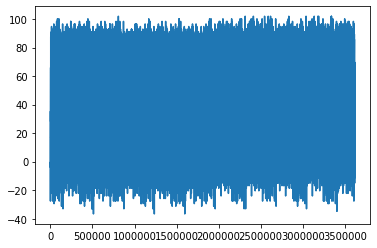

In [9]:
plt.plot(temp_C)
plt.show()

In [ ]:
plt.plot(temp_C)
plt.show()

In [44]:
# approximation valid for
# 0 degC < T < 60 degC
# 1% < RH < 100%
# 0 degC < Td < 50 degC 

# constants
a = 17.271
b = 237.7 # degC

# sys.argv[0] is program name
T=temp_C
RH=[weather_data.humidity]




In [47]:
def dewpoint_approximation(T,RH):
    
    Td = (b * gamma(T,RH)) / (a - gamma(T,RH))
    
    return Td
    

def gamma(T,RH):
    
    g = (a * T / (b + T)) + np.log(RH/100.0)
    
    return g 


In [ ]:
Td = dewpoint_approximation(T,RH)
print 'T, RH',T,RH
print 'Td=',Td